In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from mappings import map_country_id_to_country_name
from mappings import map_month_id_to_datetime
import matplotlib.dates as mdates
import math

## Notebook to generate plots used in the Data-Section highlighting Over-Dispersion, Zero-Inflation and geographical imbalances

In [192]:
# Set the data which should be used in the plots (fot the Data section this is the data with all observations)
feature_set = 'All'
year = ""
data = pd.read_parquet(fr'C:\Users\Uwe Drauz\Documents\bachelor_thesis_local\personal_competition_data\data\cm_features_allyears_feature_set{feature_set}{year}_nonadrop.parquet') 

Setting Color themes for the plots

In [226]:
teal = '#008080'
color_palette_blues = sns.color_palette('Blues_r', 10)
color_palette_crest = sns.color_palette('crest_r', 10)
colormap_deep_custom = sns.color_palette('deep', 10); colormap_deep_custom.insert(8, colormap_deep_custom.pop(3)); colormap_deep_custom.pop(6); colormap_deep_custom.insert(6, teal); colormap_deep_custom
color_palette_default = sns.color_palette()
color_palette_viridis = sns.color_palette('viridis', 10)
default_blue_dark = color_palette_blues[0]
default_blue_medium_dark = color_palette_blues[2]
default_blue_light = color_palette_blues[6]
default_crest_color = color_palette_crest[2]
blusish_grey = '#708090'

In [224]:
# Set color_palette for line plot
colormap = colormap_deep_custom; colormap

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 '#008080',
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [195]:
# Optional setting for consistent font sized throughout the plots (not yet used)
legend_text_size = 12
title_text_size = 16
yax_text_size = 14
xax_text_size = 14

In [196]:
# Function to obtain relevant subsets of countries
def get_country_subsets(data):
    # Calculate the share of zeros for each 'country_id'.
    share_of_zeros = data.groupby('country_id')[
        'ged_sb'].apply(lambda x: (x == 0).mean())
    
    # Calculate the average fatalities for each 'country_id'.
    average_fatalities = data.groupby('country_id')['ged_sb'].mean()
    
    # Combine the results into a new DataFrame.
    desired_data = pd.DataFrame({
        'country_id': share_of_zeros.index,
        'share_structured_zeros': share_of_zeros.values,
        'avg_fatalities_per_month': average_fatalities.values
    })
    # Calculate quantiles of share of structured zeros in fatalities and average fatalities per month per country (fatalities = ged_sb) excluding the countries with structured zeros share of 1
    structured_zeros_quantiles = desired_data['share_structured_zeros'].quantile([0.25, 0.5, 0.75])
    avg_fatalities_quantiles = desired_data['avg_fatalities_per_month'].quantile([0.25, 0.5, 0.75])
    # Determine all countries
    all_countries = data['country_id'].unique()
    # Determine countries with at least one conflict fatality
    countries_non_zero = data[data['ged_sb'] > 0]['country_id'].unique()
    # Determine countries whose the average fatalities per month are greater than the 0.75 quantile of average fatalities per month
    countries_over_quantile = desired_data[desired_data['avg_fatalities_per_month'] > avg_fatalities_quantiles[0.75]][
        'country_id'].unique()
    
    return all_countries, countries_non_zero, countries_over_quantile

In [197]:
all_countries, countries_non_zero, countries_over_quantile = get_country_subsets(data)

## Plotting functions

**Plots to highlight geographical imbalances**

Lollipop plots

In [198]:
# Version in which the markersize is not proportional to the percentage of fatalities
def plot_fatalities_lollipop_chart(df):
    """
    Plots a lollipop chart showing the distribution of conflict fatalities per country.
    It includes 10 dots for the countries with the highest fatalities and 1 for the remaining countries.
    
    Args:
    df (pandas.DataFrame): DataFrame containing conflict data with columns 'country_id' and 'ged_sb'.
    """
    # Aggregating total fatalities by country
    total_fatalities_by_country = df.groupby('country_id')['ged_sb'].sum().sort_values(ascending=False)

    # Top 10 countries and others
    top_countries = total_fatalities_by_country.head(10)
    others = total_fatalities_by_country[10:].sum()
    other_series = pd.Series(others, index=['Others'])
    data = pd.concat([top_countries, other_series])

    # Sort data by total fatalities
    data.sort_values(ascending=True, inplace=True)
    
        # Apply the mapping function to the index, excluding 'Others'
    data.index = [id if id == 'Others' else map_country_id_to_country_name(id) for id in data.index]
    
    # Caluclate percentage of fatalities for each elemtn in data
    data_percentage = data / data.sum() * 100
    
    # Creating the lollipop plot
    fig, ax = plt.subplots(figsize=(5, 6))
    ax.hlines(y=data.index, xmin=0, xmax=data.values, color=blusish_grey)
    
    ax.plot(data.values, data.index, "o", markersize=10, color=default_blue_medium_dark)
    
    
    # Adding the data values at the end of each lollipop
    for i, value in enumerate(data_percentage.values):
        ax.text(value, i, f'{value:.2f}%', ha='left', va='center', color=default_blue_medium_dark)

    # Setting title and labels
    ax.set_title('Distribution of Conflict Fatalities per Country')
    ax.set_xlabel('Number of Fatalities')
    ax.set_ylabel('Country')

    plt.show()

    return data  # Return the data for reference

In [199]:
# Version in which the xticks labels are not in thousands
def plot_fatalities_lollipop_chart(df):
    """
    Plots a lollipop chart showing the distribution of conflict fatalities per country.
    It includes 10 dots for the countries with the highest fatalities and 1 for the remaining countries.
    
    Args:
    df (pandas.DataFrame): DataFrame containing conflict data with columns 'country_id' and 'ged_sb'.
    """
    # Aggregating total fatalities by country
    total_fatalities_by_country = df.groupby('country_id')['ged_sb'].sum().sort_values(ascending=False)

    # Top 10 countries and others
    top_countries = total_fatalities_by_country.head(10)
    others = total_fatalities_by_country[10:].sum()
    other_series = pd.Series(others, index=['Others'])
    data = pd.concat([top_countries, other_series])

    # Sort data by total fatalities
    data.sort_values(ascending=True, inplace=True)

    # Apply the mapping function to the index, excluding 'Others'
    data.index = [id if id == 'Others' else map_country_id_to_country_name(id) for id in data.index]

    # Caluclate percentage of fatalities for each elemtn in data
    data_percentage = data / data.sum() * 100
    
    # Creating the lollipop plot
    fig, ax = plt.subplots(figsize=(5, 6))
    ax.hlines(y=data.index, xmin=0, xmax=data.values, color=blusish_grey)
    # Set grid only on x-axis at intervals of 50,000
    ax.xaxis.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray')
    ax.set_xticks(range(0, int(data.values.max()) + 50000, 50000))  # Adjust the range as needed
    ax.yaxis.grid(False)  # Hide grid lines on y-axis


    
    # Base size for markers
    base_area = 400  # Adjust this as needed

    for i, (country, fatalities) in enumerate(data.items()):
        # Calculate area proportional to percentage of total fatalities
        relative_area = base_area * (data_percentage.loc[country] / data_percentage.max())
        # Use square root of area to get proportional diameter
        marker_diameter = math.sqrt(relative_area)
        ax.plot(fatalities, country, "o", markersize=marker_diameter, color=default_blue_medium_dark)

    # Setting title and labels
    ax.set_title('Distribution of Conflict Fatalities per Country')
    ax.set_xlabel('Number of Fatalities')
    ax.set_ylabel('Country')

    plt.show()


In [200]:
# Version in which the xticks labels are in thousands and the markersize is proportional to the percentage of fatalities
def plot_fatalities_lollipop_chart(df):
    """
    Plots a lollipop chart showing the distribution of conflict fatalities per country.
    It includes 10 dots for the countries with the highest fatalities and 1 for the remaining countries.
    
    Args:
    df (pandas.DataFrame): DataFrame containing conflict data with columns 'country_id' and 'ged_sb'.
    """
    # Aggregating total fatalities by country
    total_fatalities_by_country = df.groupby('country_id')['ged_sb'].sum().sort_values(ascending=False)

    # Top 10 countries and others
    top_countries = total_fatalities_by_country.head(10)
    others = total_fatalities_by_country[10:].sum()
    other_series = pd.Series(others, index=['Others'])
    data = pd.concat([top_countries, other_series])

    # Sort data by total fatalities
    data.sort_values(ascending=True, inplace=True)

    # Apply the mapping function to the index, excluding 'Others'
    data.index = [id if id == 'Others' else map_country_id_to_country_name(id) for id in data.index]

    # Caluclate percentage of fatalities for each elemtn in data
    data_percentage = data / data.sum() * 100
    
    # Creating the lollipop plot
    fig, ax = plt.subplots(figsize=(5, 6))
    ax.hlines(y=data.index, xmin=0, xmax=data.values, color=blusish_grey)
    # Set grid only on x-axis at intervals of 50,000
    ax.xaxis.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray')
    ax.yaxis.grid(False)  # Disable horizontal grid lines

    # Set x-ticks at intervals of 50,000
    xticks = range(0, int(data.values.max()) + 50000, 50000)
    ax.set_xticks(xticks)

    # Convert x-tick labels to 'in thousands' format
    xtick_labels = [f"{int(x/1000)}" for x in xticks]
    ax.set_xticklabels(xtick_labels)


    
    # Base size for markers
    base_area = 400  # Adjust this as needed

    for i, (country, fatalities) in enumerate(data.items()):
        # Calculate area proportional to percentage of total fatalities
        relative_area = base_area * (data_percentage.loc[country] / data_percentage.max())
        # Use square root of area to get proportional diameter
        marker_diameter = math.sqrt(relative_area)
        ax.plot(fatalities, country, "o", markersize=marker_diameter, color=default_blue_medium_dark)

    # Setting title and labels
    ax.set_title('Total conflict fatalities per country')
    ax.set_xlabel('Number of fatalities (in thousands)')

    plt.show()


Pie chart

In [201]:
def plot_fatalities_pie_chart_scientific(df):
    """
    Plots a scientifically-styled pie chart showing the distribution of conflict fatalities per country.
    It includes 10 segments for the countries with the highest fatalities and 1 segment for the remaining countries.
    
    Args:
    df (pandas.DataFrame): DataFrame containing conflict data with columns 'country_id' and 'ged_sb'.
    """
    # Aggregating total fatalities by country
    total_fatalities_by_country = df.groupby('country_id')['ged_sb'].sum().sort_values(ascending=False)

    # Top 10 countries and others
    top_countries = total_fatalities_by_country.head(10)
    others = total_fatalities_by_country[10:].sum()
    other_series = pd.Series(others, index=['Others'])
    data = pd.concat([top_countries, other_series])
    
    # Sort data by total fatalities
    data.sort_values(ascending=False, inplace=True)
    
    # Apply the mapping function to the index, excluding 'Others'
    data.index = [id if id == 'Others' else map_country_id_to_country_name(id) for id in data.index]
    
    # Set 11 colors for the pie chart with grey as the first color and the rest in a gradient from colormap Blues
    colors = sns.color_palette("Blues_r", 11)
    colors[0] = '#708090'
    # Setting up the pie chart
    fig, ax = plt.subplots(figsize=(9, 6))
    wedges, texts, autotexts = ax.pie(data, autopct='%1.1f%%', startangle=140, colors=colors)

    # Legend with country IDs (or names if available)
    ax.legend(wedges, data.index, title="Country ID", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")
    ax.set_title('Share on total conflict fatalities')
    ax.set_ylabel('')  # Hide the y-label

    plt.show()

    return data  # Return the data for reference


Line plot 

In [202]:
def plot_conflict_fatalities(df, colormap):
    """
    Plots the sum of conflict fatalities over time for the top 10 countries with the most fatalities,
    and one line representing the sum of fatalities for all other countries.
    The x-axis is customized to show specific years starting from 1990 in 5-year steps until 2020.
    
    Args:
    df (pandas.DataFrame): DataFrame containing conflict data with columns 'month_id', 'country_id', and 'ged_sb'.
    map_month_id_to_datetime (function): Function to map month IDs to datetime objects.
    """
    # Aggregating fatalities by country and month
    fatalities_by_country_month = df.groupby(['country_id', 'month_id'])['ged_sb'].sum().reset_index()

    # Apply the month ID to datetime mapping
    fatalities_by_country_month['month_id'] = fatalities_by_country_month['month_id'].apply(map_month_id_to_datetime)

    # Determining the top 10 countries by total fatalities
    top_countries = fatalities_by_country_month.groupby('country_id')['ged_sb'].sum().nlargest(10).index

    # Separate data for top 10 countries and others
    top_countries_data = fatalities_by_country_month[fatalities_by_country_month['country_id'].isin(top_countries)]
    other_countries_data = fatalities_by_country_month[~fatalities_by_country_month['country_id'].isin(top_countries)]
    
    # Aggregate fatalities for other countries
    other_countries_aggregated = other_countries_data.groupby('month_id')['ged_sb'].sum().reset_index()
    other_countries_aggregated['country_id'] = 'Others'

    # Combine data
    combined_data = pd.concat([top_countries_data, other_countries_aggregated])
    
    # Determine sum over fatalities for all countries
    combined_data['total_fatalities'] = combined_data.groupby('country_id')['ged_sb'].transform('sum')
    # Sort data by total fatalities
    combined_data.sort_values(by='total_fatalities', ascending=False, inplace=True)
    
    # Apply the mapping function to the index, excluding 'Others'
    combined_data.country_id = [id if id == 'Others' else map_country_id_to_country_name(id) for id in combined_data.country_id]
    
    # Set 11 colors for the with '#708090' as the first color and the rest in a gradient from tab10
    colors = list()
    colors.append('#708090')
    colors.extend(colormap)

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=combined_data, x='month_id', y='ged_sb', hue='country_id', palette=colors)
    
    # make a bold title
    plt.title('Conflict fatalities per month from 1990-2021')
    plt.xlabel('Year')
    plt.ylabel('Fatalities')
    # plt.legend(title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend(title='Countries', loc='upper right')
    # sns.set_style("whitegrid")
    plt.grid(False)
    # Set x-axis ticks
    # plt.xticks(pd.date_range(start="1990-01-01", end="2021-12-01", freq='5YS'))
        # Define x-axis formatter to show only the year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Set x-axis ticks to show every 5 years
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))

    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
    plt.show()


In [203]:
def plot_total_fatalities_over_time(df):
    """
    Plots the sum of conflict fatalities over time for all countries combined.
    
    Args:
    df (pandas.DataFrame): DataFrame containing conflict data with columns 'month_id' and 'ged_sb'.
    """
    # Aggregating fatalities by month for all countries
    total_fatalities_by_month = df.groupby('month_id')['ged_sb'].sum().reset_index()
        # Apply the month ID to datetime mapping
    total_fatalities_by_month['month_id'] = total_fatalities_by_month['month_id'].apply(map_month_id_to_datetime)

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=total_fatalities_by_month, x='month_id', y='ged_sb', color=default_blue_dark)
    
    
    plt.title('Conflict Fatalities Over Time of All Countries')
    plt.xlabel('Year')
    plt.ylabel('Sum of Fatalities')
    plt.grid(False)

    # Set x-axis ticks
    # plt.xticks(pd.date_range(start="1990-01-01", end="2020-01-01", freq='5YS'))
        # Define x-axis formatter to show only the year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Set x-axis ticks to show every 5 years
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))

    plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
    plt.show()


**Plots to highlight Zero-Inflation**

Boxplots

In [204]:
def generate_boxplots_of_share_of_zeros(data, all_countries, countries_non_zero, countries_over_quantile, color):
    """
    Generates box plots for the share of zeros in the GED-SB variable for different country subsets.

    Parameters:
    - data: The DataFrame containing the data.
    - all_countries: List of all country IDs.
    - countries_non_zero: List of country IDs with at least one conflict fatality.
    - countries_over_quantile: List of country IDs whose average fatalities per month are greater than the 0.75 quantile.
    """
    # Prepare data for box plots
    data_all_countries = data[data['country_id'].isin(all_countries)].groupby('country_id')['ged_sb'].apply(lambda x: (x == 0).mean())
    data_countries_non_zero = data[data['country_id'].isin(countries_non_zero)].groupby('country_id')['ged_sb'].apply(lambda x: (x == 0).mean())
    data_countries_over_quantile = data[data['country_id'].isin(countries_over_quantile)].groupby('country_id')['ged_sb'].apply(lambda x: (x == 0).mean())

    # Combine data into a single DataFrame for plotting
    combined_data = pd.DataFrame({
        'All Countries': data_all_countries,
        'Countries with at least\none fatality': data_countries_non_zero,
        'Countries above 75%\nquantile of average\nfatalities per month': data_countries_over_quantile
    })

    plt.figure(figsize=(6, 6))
    # Generate box plots, a bit slimmed down
    sns.boxplot(data=combined_data, color=color, width=0.4, linewidth=1, orient='v')
    plt.title('Share of zeros in conflict fatalities per country')
    plt.xlabel('Share of Zeros')
    plt.grid(False)
    plt.show()

Violin plots

In [205]:
def generate_violinplots_of_share_of_zeros(data, all_countries, countries_non_zero, countries_over_quantile, color):
    """
    Generates box plots for the share of zeros in the GED-SB variable for different country subsets.

    Parameters:
    - data: The DataFrame containing the data.
    - all_countries: List of all country IDs.
    - countries_non_zero: List of country IDs with at least one conflict fatality.
    - countries_over_quantile: List of country IDs whose average fatalities per month are greater than the 0.75 quantile.
    """
    # Prepare data for box plots
    data_all_countries = data[data['country_id'].isin(all_countries)].groupby('country_id')['ged_sb'].apply(lambda x: (x == 0).mean())
    data_countries_non_zero = data[data['country_id'].isin(countries_non_zero)].groupby('country_id')['ged_sb'].apply(lambda x: (x == 0).mean())
    data_countries_over_quantile = data[data['country_id'].isin(countries_over_quantile)].groupby('country_id')['ged_sb'].apply(lambda x: (x == 0).mean())

    # Combine data into a single DataFrame for plotting
    combined_data = pd.DataFrame({
        'All Countries': data_all_countries,
        'Countries with at least one Fatality': data_countries_non_zero,
        'Countries above 75% quantile of average fatalities per month': data_countries_over_quantile
    })

    plt.figure(figsize=(12, 8))
    # Generate violin plots and truncated the kde distributions at 0 and 1
    sns.violinplot(data=combined_data, color=color,cut=0)
    plt.title('Share of zeros in conflict fatalities per country')
    plt.ylabel('Share of Zeros')
    plt.grid(False)
    plt.show()

**Plots to highlight Over-Dispersion**

KDE plots   

In [206]:
def generate_kde_plot_log_scale(data):
    """
    Generates an adjusted combined KDE plot for the conflict fatality variable GED-SB (excluding zeros) with a logarithmic scale,
    differentiated by different country ID lists.

    Parameters:
    - data: The DataFrame containing the data.
    - all_countries: List of all country IDs.
    - countries_non_zero: List of country IDs with at least one conflict fatality.
    - countries_over_quantile: List of country IDs whose average fatalities per month are greater than the 0.75 quantile.
    """
    plt.figure(figsize=(6, 6))

    # Filter out zero values and apply log transformation to non-zero values
    data_non_zero = data[data['ged_sb'] > 0].copy()
    data_non_zero['ged_sb_log'] = np.log(data_non_zero['ged_sb'])
    mean_non_zero = data_non_zero['ged_sb'].mean()
    mean_non_zero_log = data_non_zero['ged_sb_log'].mean()
    
    # KDE for all countries
    sns.kdeplot(data_non_zero['ged_sb_log'], fill=True, color='lightblue')
    
    # Add a dotted line for the mean
    plt.axvline(mean_non_zero_log, color=sns.color_palette('Blues_r')[0], linestyle='--', label='Mean of log-transformed\nnon-zero data')
    plt.axvline(np.log(mean_non_zero), color=sns.color_palette('crest')[2], linestyle='--', label='Mean of original\nnon-zero data')

    plt.title('Distribution of log-transformed non-zero conflict fatalities')
    plt.xlabel('fatalities')
    plt.ylabel('Density')
    plt.legend(fontsize=10)
    plt.grid(False)
    # Adjust tick size
    
    plt.show()

In [207]:
def generate_kde_plot_with_poisson_log_scale(data):
    """
    Generates an adjusted combined KDE plot for the conflict fatality variable GED-SB (excluding zeros) with a logarithmic scale,
    differentiated by different country ID lists.

    Parameters:
    - data: The DataFrame containing the data.
    - all_countries: List of all country IDs.
    - countries_non_zero: List of country IDs with at least one conflict fatality.
    - countries_over_quantile: List of country IDs whose average fatalities per month are greater than the 0.75 quantile.
    """
    plt.figure(figsize=(12, 8))
    
    # Calculate mean of ged_sb
    mean = data['ged_sb'].mean()
    
    # Genearte Poisson distribution for comparison based on mean
    poisson = np.random.poisson(mean, 10000)
    # Filter out zero values and apply log transformation to non-zero values
    poisson_non_zero = poisson[poisson > 0].copy()
    poisson_non_zero_log = np.log(poisson_non_zero)
    mean_poisson = poisson_non_zero_log.mean()

    
    # Filter out zero values and apply log transformation to non-zero values
    data_non_zero = data[data['ged_sb'] > 0].copy()
    data_non_zero['ged_sb_log'] = np.log(data_non_zero['ged_sb'])
    mean_non_zero = data_non_zero['ged_sb_log'].mean()
    
    
    # KDE for all countries
    sns.kdeplot(data_non_zero['ged_sb_log'], fill=True, color='lightblue', label='Log Non-Zero Conflict Fatalities')
    # KDE poisson
    sns.kdeplot(poisson_non_zero_log, fill=True, color='lightgrey', label='Log Non Zero Poisson')
    
    # Add a dotted line for the mean
    plt.axvline(mean_non_zero, color=sns.color_palette('Blues_r')[0], linestyle='--', label='Mean')
    # Add a dotted line for the mean
    plt.axvline(mean_poisson, color='grey', linestyle='--', label='Mean Poisson')

    plt.title('Distribution of log-transformed non-zero conflict fatalities')
    plt.xlabel('fatalities')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(False)
    plt.xticks(ticks=np.log([1, 10, 100, 1000]), labels=['1', '10', '100', '1000'])  # Adjusting x-axis to show log scale labels
    plt.show()

CDF plots

In [208]:
def generate_cdf_plot(data, all_countries, countries_non_zero, countries_over_quantile):
    """
    Generates a combined CDF (Cumulative Distribution Function) plot for the conflict fatality variable GED-SB,
    differentiated by different country ID lists.

    Parameters:
    - data: The DataFrame containing the data.
    - all_countries: List of all country IDs.
    - countries_non_zero: List of country IDs with at least one conflict fatality.
    - countries_over_quantile: List of country IDs whose average fatalities per month are greater than the 0.75 quantile.
    """
    plt.figure(figsize=(12, 8))
    colors = sns.color_palette('crest_r', 3)

    # CDF for all countries
    sns.ecdfplot(data[data['country_id'].isin(all_countries)]['ged_sb'], label='All Countries', color=colors[0])

    # CDF for countries with at least one conflict fatality
    sns.ecdfplot(data[data['country_id'].isin(countries_non_zero)]['ged_sb'], label='Countries with ≥1 Fatality', color=colors[1])

    # CDF for countries over the 0.75 quantile in average fatalities per month
    sns.ecdfplot(data[data['country_id'].isin(countries_over_quantile)]['ged_sb'], label='Countries > 0.75 Quantile in Avg Fatalities', color=colors[2])

    plt.title('CDF of non-zero conflict fataltites for Different Country Groups')
    plt.xlabel('conflict fatalities')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(False)

    plt.show()

In [209]:
def generate_cdf_plot_log_scale(data, all_countries, countries_over_quantile):
    """
    Generates a combined CDF (Cumulative Distribution Function) plot with a logarithmic x-axis for the conflict fatality variable GED-SB,
    differentiated by different country ID lists.

    Parameters:
    - data: The DataFrame containing the data.
    - all_countries: List of all country IDs.
    - countries_non_zero: List of country IDs with at least one conflict fatality.
    - countries_over_quantile: List of country IDs whose average fatalities per month are greater than the 0.75 quantile.
    """
    plt.figure(figsize=(12, 8))

    # Filtering out zero values and using log scale for non-zero values
    data_non_zero = data[data['ged_sb'] > 0]

    colors = sns.color_palette('crest_r', 3)
    # CDF for all countries
    sns.ecdfplot(data_non_zero[data_non_zero['country_id'].isin(all_countries)]['ged_sb'].apply(np.log10), label='All Countries', color= colors[0])

    # CDF for countries over the 0.75 quantile in average fatalities per month
    sns.ecdfplot(data_non_zero[data_non_zero['country_id'].isin(countries_over_quantile)]['ged_sb'].apply(np.log10), label='Countries > 0.75 Quantile in Avg Fatalities', color=colors[2])

    plt.title('Combined CDF of Non-Zero Conflic Fatalties (Log Scale) for Different Country Groups')
    plt.xlabel('Conflict Fatalities (log scale)')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(False)
    plt.xticks(ticks=np.log10([1, 10, 100, 1000]), labels=['1', '10', '100', '1000'])  # Setting the x-axis to log scale

    plt.show()


Mean-Variance plots

In [210]:
def plot_mean_variance_log_scale(data, group_var='country_id', target_var='ged_sb'):
    """
    Plots a mean-variance plot on a logarithmic scale for a specified variable in the given dataset.

    Parameters:
    data (DataFrame): The pandas DataFrame containing the data.
    group_var (str): The column name to group by. Default is 'country_id'.
    target_var (str): The column name of the target variable for which mean and variance are calculated. Default is 'ged_sb'.

    Returns:
    A mean-variance plot on a logarithmic scale.
    """
    # Grouping the data and calculating mean and variance
    grouped_data = data.groupby(group_var)[target_var].agg(['mean', 'var']).replace(0, np.nan)

    # Plotting the mean-variance plot
    plt.figure(figsize=(6, 6))
    plt.scatter(grouped_data['mean'], grouped_data['var'], alpha=0.7, label='Country')
    plt.title(f'Mean-Variance plot on log-scale')
    plt.xlabel(f'Mean of fatalities')
    plt.ylabel(f'Variance in fatalities')
    plt.xscale('log')
    plt.yscale('log')

    # Adding a reference line where mean = variance (Poisson distribution)
    max_value = max(grouped_data['mean'].max(), grouped_data['var'].max())
    plt.plot([0.001, max_value], [0.001, max_value], label='Poisson', color = sns.color_palette('crest_r')[2], linestyle='--')

    plt.legend(fontsize=11)
    plt.grid(False)
    plt.show()

## Plotting the data

Over-Dispersion

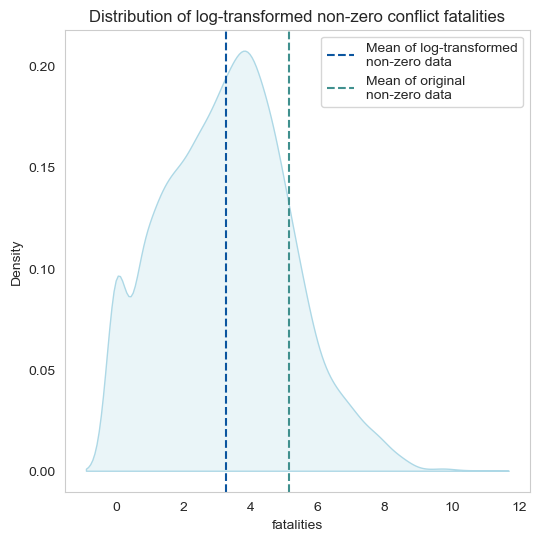

In [211]:
generate_kde_plot_log_scale(data)


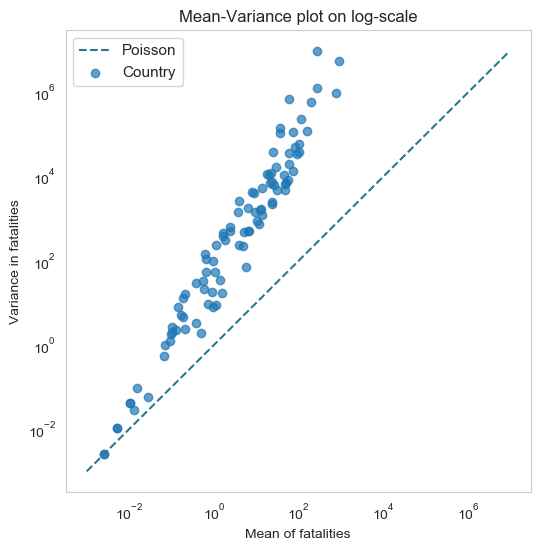

In [212]:
plot_mean_variance_log_scale(data)

Zero-Inflation

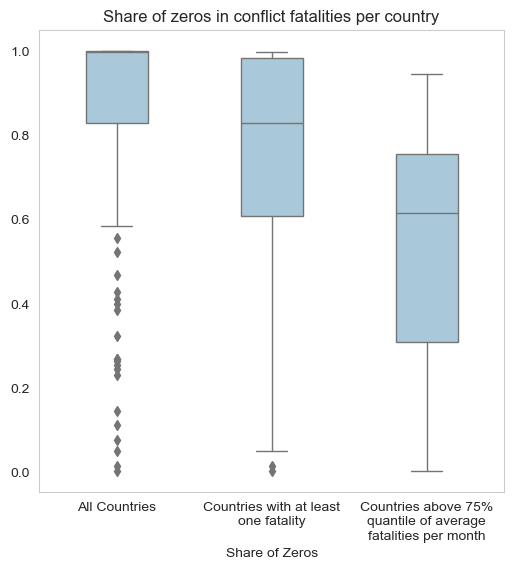

In [213]:
generate_boxplots_of_share_of_zeros(data, all_countries, countries_non_zero, countries_over_quantile,
                                    default_blue_light)

Geographical Imbalances

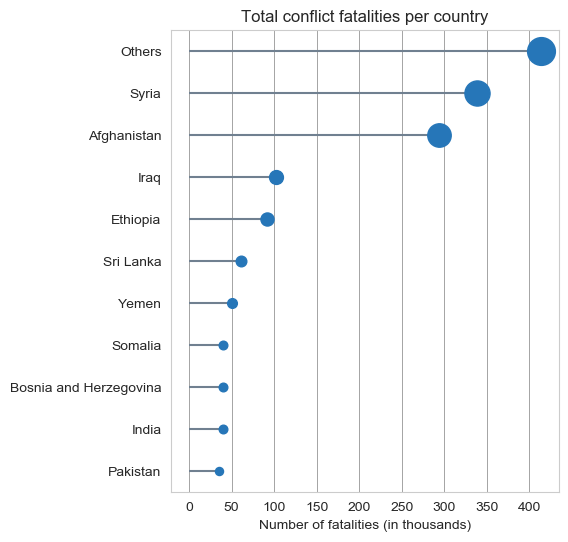

In [227]:
plot_fatalities_lollipop_chart(data)

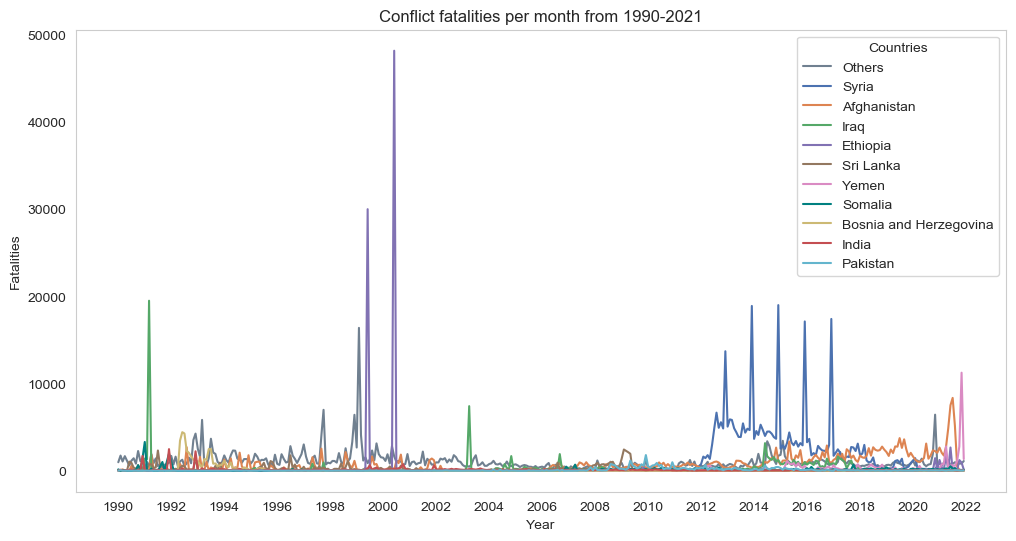

In [225]:

plot_conflict_fatalities(data, colormap)

### Exploring Other Plots

In [17]:
# Determine share of zeros for each country
share_of_zeros = data.groupby('country_id')['ged_sb'].apply(lambda x: (x == 0).mean())
# Determine average fatalities for each country
average_fatalities = data.groupby('country_id')['ged_sb'].mean()
# Combine the results into a new DataFrame
combined_data = pd.DataFrame({
    'country_id': share_of_zeros.index,
    'share_structured_zeros': share_of_zeros.values,
    'avg_fatalities_per_month': average_fatalities.values
})
# Set mask with share of zeros greater than 0.75 quantile of average fatalities per month
combined_data['mask'] = combined_data['avg_fatalities_per_month'] > combined_data['avg_fatalities_per_month'].quantile(0.75)
combined_data

,country_id,share_structured_zeros,avg_fatalities_per_month,mask
0,1,1.000000,0.000000,False
1,2,1.000000,0.000000,False
2,3,0.994792,0.101562,False
3,4,0.989583,0.382812,False
4,5,1.000000,0.000000,False
...,...,...,...,...
186,242,0.987138,0.125402,False
187,243,0.989583,0.070312,False
188,244,0.986979,0.065104,False
189,245,0.269841,48.793651,True


<Axes: xlabel='share_structured_zeros'>

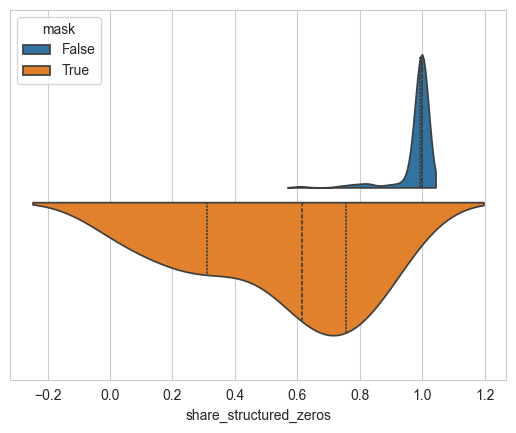

In [25]:
# Make a violin plot of share of zeros and use 'mask' as hue and split=True to split the violins
sns.violinplot(data=combined_data, x='share_structured_zeros', hue='mask', split=True, inner='quartile', gap=0.1)

In [64]:
def plot_combined_fatalities(df, colormap):
    """
    Creates a combined visualization with a pie chart showing the distribution of conflict fatalities per country
    on the left and a line plot showing the sum of conflict fatalities over time for the top 10 countries with
    the most fatalities on the right. The pie chart includes 10 segments for the countries with the highest
    fatalities and 1 segment for the remaining countries.

    Args:
    df (pandas.DataFrame): DataFrame containing conflict data with columns 'month_id', 'country_id', and 'ged_sb'.
    map_month_id_to_datetime (function): Function to map month IDs to datetime objects.
    """

    # --- Pie Chart Data Preparation ---
    total_fatalities_by_country = df.groupby('country_id')['ged_sb'].sum().sort_values(ascending=False)
    top_countries = total_fatalities_by_country.head(10)
    others = total_fatalities_by_country[10:].sum()
    others_series = pd.Series([others], index=['Others'])
    pie_data = pd.concat([top_countries, others_series])
    pie_data.sort_values(ascending=False, inplace=True)
    pie_data.index = [id if id == 'Others' else map_country_id_to_country_name(id) for id in pie_data.index]

    # --- Line Plot Data Preparation ---
    fatalities_by_country_month = df.groupby(['country_id', 'month_id'])['ged_sb'].sum().reset_index()
    fatalities_by_country_month['month_id'] = fatalities_by_country_month['month_id'].apply(map_month_id_to_datetime)
    top_countries = fatalities_by_country_month.groupby('country_id')['ged_sb'].sum().nlargest(10).index
    top_countries_data = fatalities_by_country_month[fatalities_by_country_month['country_id'].isin(top_countries)]
    other_countries_data = fatalities_by_country_month[~fatalities_by_country_month['country_id'].isin(top_countries)]
    other_countries_aggregated = other_countries_data.groupby('month_id')['ged_sb'].sum().reset_index()
    other_countries_aggregated['country_id'] = 'Others'
    line_data = pd.concat([top_countries_data, other_countries_aggregated])

    # --- Combined Plotting ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 2]})

    # Pie Chart
    colors = sns.color_palette("Blues_r", 11)
    colors[0] = '#708090'
    wedges, texts, autotexts = ax1.pie(pie_data, autopct='%1.1f%%', startangle=140, colors=colors)
    ax1.set_title('Conflict Fatalities Distribution')
    plt.setp(autotexts, size=8, weight="bold")

    # Line Plot
    line_colors = ['#708090'] + sns.color_palette(colormap, 10)
    sns.lineplot(data=line_data, x='month_id', y='ged_sb', hue='country_id', palette=line_colors, ax=ax2)
    ax2.set_title('Conflict Fatalities Over Time')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Sum of Fatalities')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax2.xaxis.set_major_locator(mdates.YearLocator(5))
    ax2.legend(title='Countries', loc='upper right').remove()

    # Combined Legend
    fig.legend(wedges + ax2.lines, pie_data.index.tolist() + line_data['country_id'].unique().tolist(), loc='center right', title='Countries')

    plt.subplots_adjust(right=0.85)  # Adjust subplot to fit the legend
    plt.show()
    